In [7]:
import torch
from torch.utils.data import DataLoader, RandomSampler
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from diffusion import DiffusionPipeline
from diffusion.unet import UNet
import os
from diffusion.config import Config
import time
import json
from contrastive_feature.encoder import ContrastiveEncoder
from contrastive_feature.loss import SupConLoss
from contrastive_feature.config import Config as ContrastiveConfig

In [21]:
def train(dataloader: DataLoader, encoder: ContrastiveEncoder, sup_con_loss: SupConLoss, optimizer, device):
    losses = []
    size = len(dataloader.dataset)
    encoder.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        X, t = encoder.add_noise(X)
        loss = sup_con_loss(encoder(X, t), labels=y)
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        # print loss
        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f'loss: {loss:>7f}, [{current:>5d}/{size:>5d}]', end='\r')
    return sum(losses) / len(losses)

def validate(dataloader: DataLoader, encoder: ContrastiveEncoder, device, _t1, _t2=None):
    if _t2 is None:
        _t2 = _t1
    encoder.eval()
    reference = []
    for i, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        break
    X, t = encoder.add_noise(X, torch.ones_like(y, dtype=torch.int)*_t1)
    with torch.no_grad():
        for i in range(10):
            first_i_index = (y == i).nonzero(as_tuple=True)[0][0]
            features_i = encoder(X[first_i_index].unsqueeze(0), t[first_i_index].unsqueeze(0)).squeeze()
            reference.append(features_i)
    reference = torch.stack(reference)
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            X, t = encoder.add_noise(X, torch.ones_like(y, dtype=torch.int)*_t2)
            features = encoder(X, t)
            # print(features.shape, reference.shape)
            similarity = features @ reference.mT
            _, predicted = torch.max(similarity, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return correct / total

In [9]:
bs=512
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST('./F_MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.MNIST('./F_MNIST_data/', download=True, train=False, transform=transform)

testloader = DataLoader(testset, batch_size=bs, shuffle=True)


In [10]:
device = 'cuda'
config = ContrastiveConfig(
    in_channels=1,
    out_channels=10,
    hidden_channels=32
)
encoder = ContrastiveEncoder(device, config).to(device)
# encoder.load_state_dict(torch.load('exp_20241108-173956_cls10\checkpoint_5.pth'))
epochs = 30
learning_rate = 3e-2
optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


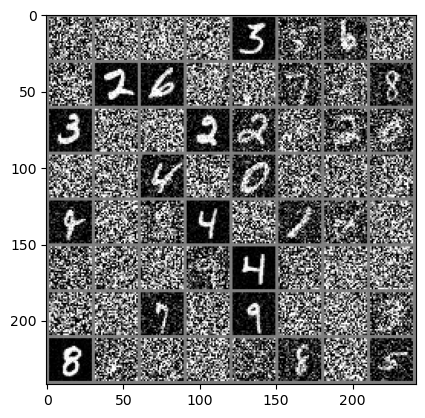

In [11]:

def imshow(img):
    img = torchvision.utils.make_grid(img)
    img = img / 2 + 0.5  # 反归一化
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))  # 转换为正确的图片格式
    plt.show()
for i, (X, y) in enumerate(testloader):
    X, y = X.to(device), y.to(device)
    break
X, t = encoder.add_noise(X)
imshow(X[:64].cpu())


Epoch 1-------------------------------
loss: 3.067696, [56832/60000]
accuracy: 0.523100

Epoch 2-------------------------------
loss: 3.055576, [56832/60000]
accuracy: 0.610000

Epoch 3-------------------------------
loss: 3.063107, [56832/60000]
accuracy: 0.663000

Epoch 4-------------------------------
loss: 3.032976, [56832/60000]
accuracy: 0.646000

Epoch 5-------------------------------
loss: 3.043304, [56832/60000]
accuracy: 0.715900

Epoch 6-------------------------------
loss: 3.043312, [56832/60000]
accuracy: 0.722600

Epoch 7-------------------------------
loss: 3.022380, [56832/60000]
accuracy: 0.746600

Epoch 8-------------------------------
loss: 3.000963, [56832/60000]
accuracy: 0.798200

Epoch 9-------------------------------
loss: 2.989702, [56832/60000]
accuracy: 0.710000

Epoch 10-------------------------------
loss: 3.001593, [56832/60000]
accuracy: 0.660900

Epoch 11-------------------------------
loss: 3.033161, [56832/60000]
accuracy: 0.758900

Epoch 12----------

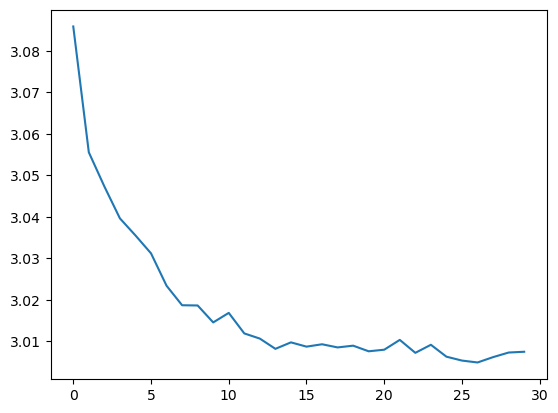

In [12]:
timestamp = time.strftime("%Y%m%d-%H%M%S")
# create the folder if not exists
if not os.path.exists(f'./exp_{timestamp}_c'):
    os.makedirs(f'./exp_{timestamp}_c')
# save the config
with open(f'./exp_{timestamp}_c/config.json', 'w') as f:
    json.dump(vars(config), f)
    
losses = []

for t in range(epochs):
    trainloader = DataLoader(trainset, batch_size=bs, shuffle=True)
    print(f'\nEpoch {t+1}-------------------------------')
    loss_fn = SupConLoss()
    loss = train(trainloader, encoder, loss_fn, optimizer, device)
    acc = validate(testloader, encoder, device, 0)
    print(f'\naccuracy: {acc:>7f}')
    losses.append(loss)
    scheduler.step()
    if (t+1) % 10 == 0:
        torch.save(encoder.state_dict(), f'./exp_{timestamp}_c/checkpoint_{t+1}.pth')
        
# plot losses line chart
plt.plot(losses)

In [31]:
validate(testloader, encoder, device, 800, 800)

0.1035

In [ ]:
for i, (X, y) in enumerate(testloader):
    X, y = X.to(device), y.to(device)
    break
with torch.no_grad():
    for i in range(10):
        first_i_index = (y == i).nonzero(as_tuple=True)[0][0]
        features_i = encoder.training_features(X[first_i_index].unsqueeze(0), torch.ones(1, dtype=torch.int)*200).squeeze()

done


In [6]:
# channels = 10
# device = 'cuda'
# encoder = ContrastiveEncoder(1, channels).to(device)
encoder.eval()
# encoder.load_state_dict(torch.load('exp_20241108-180201_c10\checkpoint_30.pth'))
features = encoder(X)
# features = torch.nn.Softmax(dim=1)(features)

In [7]:
torch.set_printoptions(precision=2, linewidth=200, sci_mode=False)
print(features[0:10])

tensor([[-0.51, -0.16, -0.31, -0.55,  0.40,  0.19, -0.30, -0.15,  0.03, -0.11],
        [-0.02,  0.04,  0.18,  0.23,  0.59, -0.55,  0.28,  0.13,  0.08, -0.40],
        [ 0.29,  0.29, -0.14,  0.56, -0.48,  0.35, -0.15,  0.36, -0.01, -0.07],
        [ 0.14, -0.22,  0.43, -0.02, -0.40, -0.16,  0.27, -0.36, -0.46,  0.39],
        [ 0.19,  0.25, -0.07,  0.62, -0.47,  0.34, -0.14,  0.31, -0.22, -0.14],
        [ 0.42,  0.11, -0.25, -0.19, -0.06,  0.00, -0.05,  0.17,  0.77,  0.29],
        [ 0.30, -0.09,  0.36,  0.22, -0.58, -0.05,  0.21, -0.20, -0.40,  0.37],
        [ 0.61, -0.19, -0.32,  0.51, -0.09, -0.30, -0.23,  0.17, -0.13,  0.20],
        [-0.40,  0.29,  0.45,  0.14, -0.35,  0.40,  0.23, -0.02, -0.35, -0.28],
        [-0.05,  0.27,  0.29, -0.48, -0.12,  0.16,  0.33, -0.05,  0.66,  0.15]], device='cuda:0', grad_fn=<SliceBackward0>)


In [9]:
matrix = features @ features.T
normalized_matrix = matrix / matrix.norm(dim=-1, keepdim=True)

In [10]:
torch.set_printoptions(precision=2, linewidth=200, sci_mode=False)
print(matrix[:8, :8])

tensor([[ 1.00, -0.10, -0.58, -0.43, -0.57, -0.09, -0.70, -0.53],
        [-0.10,  1.00, -0.33, -0.25, -0.29, -0.18, -0.35,  0.01],
        [-0.58, -0.33,  1.00, -0.16,  0.96,  0.15,  0.27,  0.47],
        [-0.43, -0.25, -0.16,  1.00, -0.05, -0.36,  0.91,  0.07],
        [-0.57, -0.29,  0.96, -0.05,  1.00, -0.11,  0.34,  0.42],
        [-0.09, -0.18,  0.15, -0.36, -0.11,  1.00, -0.23,  0.22],
        [-0.70, -0.35,  0.27,  0.91,  0.34, -0.23,  1.00,  0.31],
        [-0.53,  0.01,  0.47,  0.07,  0.42,  0.22,  0.31,  1.00]], device='cuda:0', grad_fn=<SliceBackward0>)


In [8]:
print(y[:8])

tensor([7, 1, 8, 0, 8, 5, 0, 6], device='cuda:0')


In [73]:
reference = []
with torch.no_grad():
    for i in range(10):
        first_i_index = (y == i).nonzero(as_tuple=True)[0][0]
        features_i = encoder(X[first_i_index].unsqueeze(0)).squeeze()
        print(f'features_{first_i_index}: {features_i}')
        reference.append(features_i)

features_9: tensor([    -0.00,     -9.24,    -20.54,     -0.00,     -4.58,     -0.00,      4.29,    -16.51,      0.00,     -0.00], device='cuda:0')
features_4: tensor([     0.00,    -17.78,     -0.94,      0.00,      5.33,      0.00,     -7.02,      9.46,     -0.00,      0.00], device='cuda:0')
features_5: tensor([    -0.00,      9.60,      0.65,     -0.00,     16.00,     -0.00,     16.52,     -2.97,      0.00,      0.00], device='cuda:0')
features_17: tensor([    -0.00,     14.59,      4.94,     -0.00,      0.48,      0.00,    -12.82,     19.83,      0.00,     -0.00], device='cuda:0')
features_15: tensor([    -0.00,     -1.78,     29.69,     -0.00,      0.43,      0.00,     -6.24,     -1.78,     -0.00,     -0.00], device='cuda:0')
features_6: tensor([     0.00,     10.86,      9.33,     -0.00,    -15.32,     -0.00,      5.36,     31.77,     -0.00,     -0.00], device='cuda:0')
features_3: tensor([    -0.00,    -13.07,      6.71,      0.00,    -21.60,     -0.00,     57.69,     -8.15,   

In [75]:
correct = 0
total = 0
with torch.no_grad():
    encoder.eval()
    for i, (X, y) in enumerate(testloader):
        X, y = X.to(device), y.to(device)
        features = encoder(X)
        similarity = features @ torch.stack(reference).T
        _, predicted = torch.max(similarity, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
print(f'Accuracy: {100 * correct / total:.2f}%')
        

Accuracy: 93.64%


In [ ]:
def imshow(img):
    img = torchvision.utils.make_grid(img)
    img = img / 2 + 0.5  # 反归一化
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))  # 转换为正确的图片格式
    plt.show()


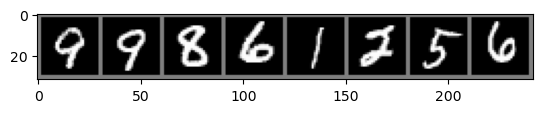

In [44]:
imshow(torchvision.utils.make_grid(X.cpu()[:8]))

In [28]:
loss_fn(features, y)

Traceback (most recent call last):
  File "c:\Users\dada\miniconda3\lib\site-packages\debugpy\_vendored\pydevd\_pydevd_bundle\pydevd_vars.py", line 624, in change_attr_expression
    value = eval(expression, frame.f_globals, frame.f_locals)
  File "<string>", line 1, in <module>
NameError: name 'tensor' is not defined


tensor(2.41, device='cuda:0', grad_fn=<MeanBackward0>)